In [1]:
import tensorflow as tf

from qiskit import QuantumCircuit
from math import asin, sqrt, ceil
from qiskit.opflow import Z, CircuitStateFn, StateFn, PauliExpectation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from scipy.signal import detrend
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Layer

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7]
%config InlineBackend.figure_format = 'retina'

In [2]:
tf.executing_eagerly()

True

In [3]:
fano_data = pd.read_csv("./../datasets/signal_080_peak_1_fano_adjust.csv")

In [4]:
def func_fano(x, xc, w, q, y0):
    y = y0+A*(2*(x-xc)/w+q)*(2*(x-xc)/w+q)/(2*(x-xc)/w*2*(x-xc)/w+1)/(1+q*q)
    return y

def scale(arr, lvalue = -np.pi, rvalue = np.pi):
    return np.interp(arr, (arr.min(), arr.max()), (lvalue, rvalue))

def remove_outlier(df_in, col_name, quartiles, rng_arr):
    q1 = df_in[col_name].quantile(quartiles[0])
    q3 = df_in[col_name].quantile(quartiles[1])
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-rng_arr[0]*iqr
    fence_high = q3+rng_arr[1]*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [5]:
def smooth(data):
    #return data
    #return scipy.ndimage.gaussian_filter(data, sigma=30, mode='reflect', truncate=18.0)
    
    return gaussian_filter(data, sigma=15, mode='reflect', truncate=18.0)
    #return scipy.ndimage.gaussian_filter(data, sigma=15, mode='reflect', truncate=15.0)

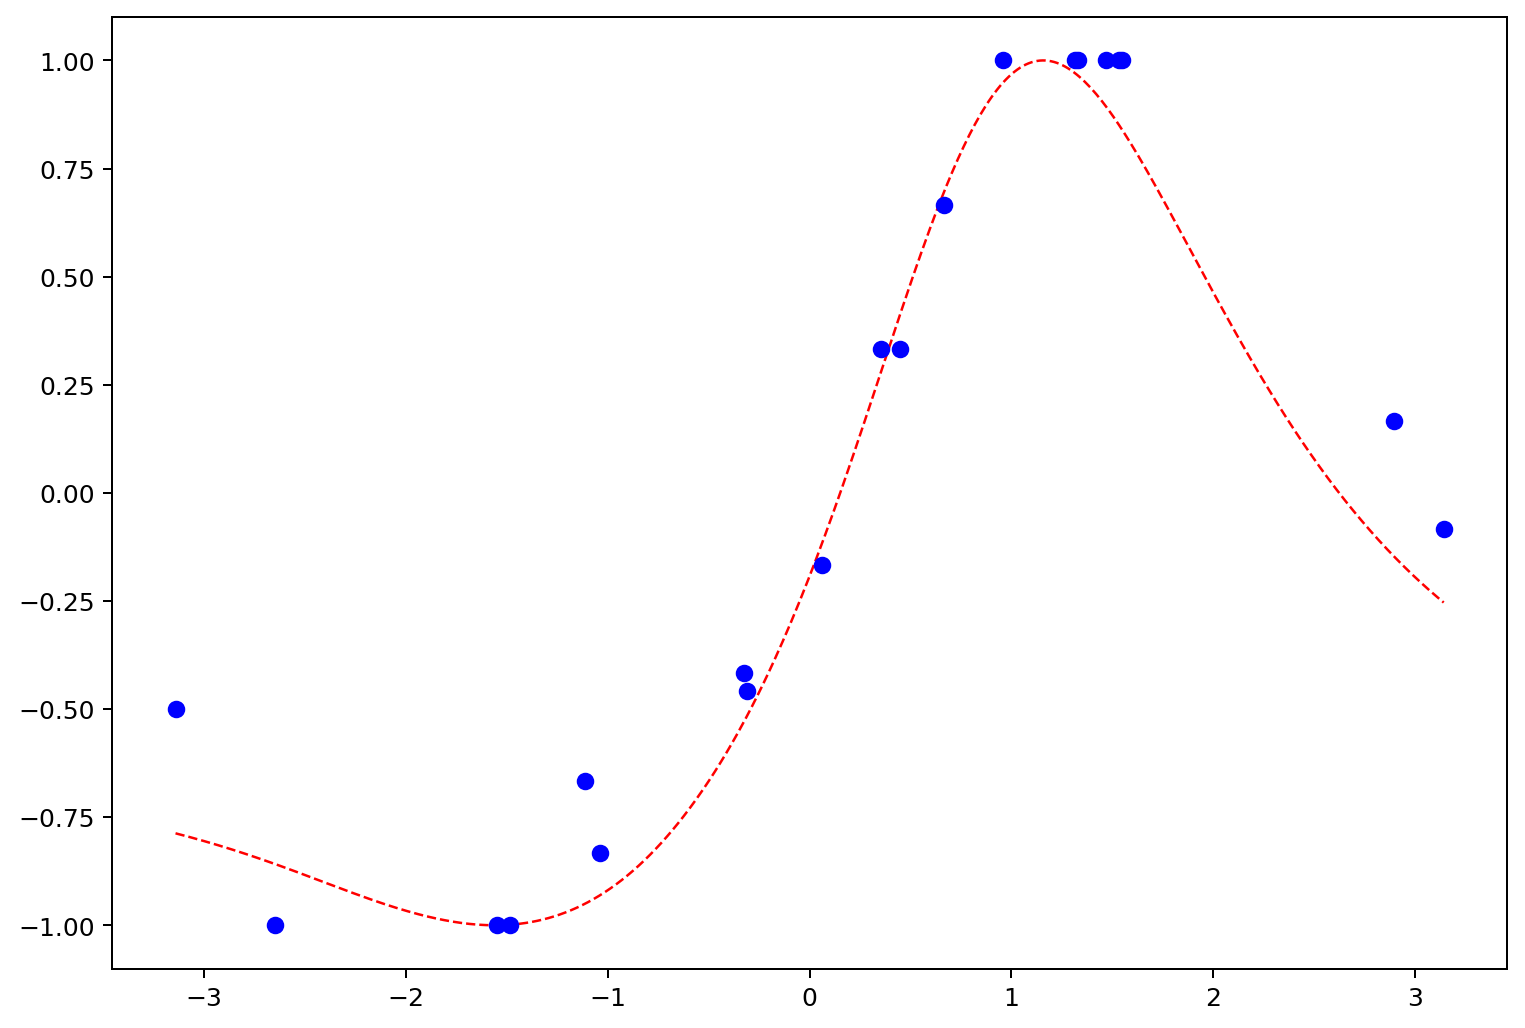

In [6]:
num_samples = 20
eps = 0.2
lb, ub = -1, 1

y0 = fano_data["y0"].values[0]
A = fano_data["A"].values[0]
xc = fano_data["xc"].values[0]
q = fano_data["q"].values[0]
w = fano_data["w"].values[0]

f = lambda x: func_fano(x, xc, w, q, y0)

X_ = fano_data["signal_original_x"].values.reshape(-1,1)

# Create Gaussian distribution (mean = 0, std = 1)
std_scaler = StandardScaler()
std_scaler.fit(X_)
X_ = std_scaler.transform(X_)

#y_ = f(X_)

y_ = fano_data["signal_original_y"].values

# select a better range of data to fit
rng = range(250,700)

X_ = X_.take(rng, axis=0)
y_ = y_.take(rng, axis=0)

# random indices for points selection
#indices = sorted(np.random.choice(range(X_.shape[0]), num_samples, replace=False))

#indices = np.array([19,  40, 156, 159, 173, 175, 191, 207, 213, 253, 358, 359, 448, 543, 559, 613, 651, 657, 737, 754])
indices = [22, 54, 125, 129, 153, 158, 204, 205, 229, 248, 254, 268, 287, 310, 311, 320, 324, 325, 412, 428]

XX = X_[indices].reshape(-1,1)
yy = y_[indices].reshape(-1,1)

#df = pd.DataFrame(zip(X[:,0].flatten().tolist(), y[:,0].flatten().tolist()), columns = ["X", "y"])
#new_df = remove_outlier(df, "y", [0.25, 0.75], [0.05, 0.05])
#X = new_df["X"].values.reshape(-1,1)
#y = new_df["y"].values.reshape(-1,1)

yy = detrend(yy)

#XX = scale(XX, 0, 1)
XX = scale(XX) # from -pi to pi
yy = scale(yy, -1, 1)

#X_ = scale(X_, 0, 1)
X_ = scale(X_) # from -pi to pi
y_ = scale(y_, -1, 1)

plt.figure(num = "Fano adjust data", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')
plt.plot(X_, y_, "r--", label='Tx signal', linewidth = 1)
plt.plot(XX, yy, "bo", label = 'Points to fit')
plt.show()

In [7]:
def prob_to_angle(prob):
    return 2*asin(sqrt(prob))

In [8]:
def quantum_layer(initial_parameters, num_qubits):

    expectations = []
    
    for i in range(len(initial_parameters)):
        
        quantumCircuit = QuantumCircuit(num_qubits)

        #quantumCircuit.h(range(num_qubits))
    
        angles = initial_parameters[i]
        
        for j in range(len(angles)):
            #quantumCircuit.ry(prob_to_angle(angles[j]), j)
            #quantumCircuit.ry(angles[j] * np.pi, j)
            quantumCircuit.ry(angles[j], j)

        #quantumCircuit.h(range(num_qubits))
 
        operator = Z
        for _ in range(num_qubits - 1):
            operator @= Z
          
        psi = StateFn(quantumCircuit)
        #psi = CircuitStateFn(quantumCircuit)
        #expectation_value = psi.adjoint().compose(operator).compose(psi).eval() 
        expectation_value = (~psi @ operator @ psi).eval()
        #expectation_value = PauliExpectation().convert(expectation_value).eval()

        expectations.append(expectation_value)
 
    diff = num_qubits - len(expectations)
    
    if diff > 0:
        for _ in range(diff):
            expectations.append(0j)
    
    return expectations

In [9]:
class Linear(Layer):
    
    def __init__(self, output_size, batch_size = 10, units = 1, input_dim=1, num_qubits = 1, **kwargs):
        
        super(Linear, self).__init__(**kwargs)
        #self.threshold = 0.5
        self.num_qubits = num_qubits
        self.output_size = output_size

        self.w = self.add_weight(
            shape=(input_dim, units), initializer="random_normal", trainable=True
        )
        
        self.b = self.add_weight(shape=(units,), initializer="zeros", trainable=True)


    def build(self,input_shape): 
        self.input_size = input_shape[1]        
        self.w = self.add_weight(shape=(self.input_size,
                                          self.output_size),
                                   initializer='random_normal',
                                   trainable=True)

    def get_config(self):
        config = super(Linear, self).get_config()
        return config

    def call(self, inputs):
        
        if (tf.executing_eagerly()):
            
            final_output = []
        
            for i in range(inputs.shape[0]):
                pred = quantum_layer(inputs.numpy(), self.num_qubits)
                final_output.append(list(pred))

            return tf.convert_to_tensor(final_output)
        
        return inputs

In [10]:
n_qubits = 1

In [11]:
def sequential_model():

    layers_arr = []
    layers_arr.append(Dense(n_qubits, activation = 'relu', input_shape = [1], name = "dense1"))
    layers_arr.append(Linear(output_size = n_qubits, units = 1, input_dim = n_qubits, num_qubits = n_qubits, name = "quantum1"))
    #layers_arr.append(Dense(n_qubits, activation="linear", name = "dense2"))
    layers_arr.append(Dense(1, activation="linear", name ="dense3"))

    return Sequential(layers_arr)

In [12]:
model = sequential_model()
    
#optimizer = Adam(learning_rate=0.01)
optimizer = SGD(learning_rate=0.01)

#model.compile(loss='mse', optimizer = optimizer, metrics = ['mae', 'mse', 'acc'], run_eagerly=True)
model.compile(optimizer, loss='mse', metrics=["accuracy"], run_eagerly=True)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 1)                 2         
_________________________________________________________________
quantum1 (Linear)            (None, 1)                 2         
_________________________________________________________________
dense3 (Dense)               (None, 1)                 2         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(XX, yy, epochs=100, batch_size=n_qubits, validation_split = 0.33)

#history = model.fit(XX, yy, epochs = 50, batch_size=n_qubits, validation_split = 0.25)

Epoch 1/100
13/13 [==============================] - 0s 18ms/step - loss: 0.5165 - accuracy: 0.0769 - val_loss: 0.1931 - val_accuracy: 0.7143
Epoch 2/100
13/13 [==============================] - 0s 17ms/step - loss: 0.3536 - accuracy: 0.0769 - val_loss: 0.2080 - val_accuracy: 0.7143
Epoch 3/100
13/13 [==============================] - 0s 20ms/step - loss: 0.2669 - accuracy: 0.0000e+00 - val_loss: 0.2528 - val_accuracy: 0.0000e+00
Epoch 4/100
 1/13 [=>............................] - ETA: 0s - loss: 0.0771 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


13/13 [==============================] - 0s 19ms/step - loss: 0.2192 - accuracy: 0.0000e+00 - val_loss: 0.3076 - val_accuracy: 0.0000e+00
Epoch 5/100
13/13 [==============================] - 0s 19ms/step - loss: 0.1947 - accuracy: 0.0000e+00 - val_loss: 0.3508 - val_accuracy: 0.0000e+00
Epoch 6/100
13/13 [==============================] - 0s 19ms/step - loss: 0.1827 - accuracy: 0.0000e+00 - val_loss: 0.3880 - val_accuracy: 0.0000e+00
Epoch 7/100
10/13 [======================>.......] - ETA: 0s - loss: 0.2208 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


13/13 [==============================] - 0s 18ms/step - loss: 0.1757 - accuracy: 0.0000e+00 - val_loss: 0.4205 - val_accuracy: 0.0000e+00
Epoch 8/100
13/13 [==============================] - 0s 18ms/step - loss: 0.1721 - accuracy: 0.0000e+00 - val_loss: 0.4422 - val_accuracy: 0.0000e+00
Epoch 9/100
13/13 [==============================] - 0s 20ms/step - loss: 0.1704 - accuracy: 0.0000e+00 - val_loss: 0.4557 - val_accuracy: 0.0000e+00
Epoch 10/100
13/13 [==============================] - 0s 20ms/step - loss: 0.1695 - accuracy: 0.0000e+00 - val_loss: 0.4701 - val_accuracy: 0.0000e+00
Epoch 11/100
 1/13 [=>............................] - ETA: 0s - loss: 0.0181 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


13/13 [==============================] - 0s 17ms/step - loss: 0.1687 - accuracy: 0.0000e+00 - val_loss: 0.4834 - val_accuracy: 0.0000e+00
Epoch 12/100
13/13 [==============================] - 0s 18ms/step - loss: 0.1684 - accuracy: 0.0000e+00 - val_loss: 0.4888 - val_accuracy: 0.0000e+00
Epoch 13/100
13/13 [==============================] - 0s 16ms/step - loss: 0.1682 - accuracy: 0.0000e+00 - val_loss: 0.4934 - val_accuracy: 0.0000e+00
Epoch 14/100
 6/13 [============>.................] - ETA: 0s - loss: 0.1894 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


13/13 [==============================] - 0s 17ms/step - loss: 0.1678 - accuracy: 0.0000e+00 - val_loss: 0.5036 - val_accuracy: 0.0000e+00
Epoch 15/100
13/13 [==============================] - 0s 16ms/step - loss: 0.1678 - accuracy: 0.0000e+00 - val_loss: 0.4981 - val_accuracy: 0.0000e+00
Epoch 16/100
13/13 [==============================] - 0s 17ms/step - loss: 0.1679 - accuracy: 0.0000e+00 - val_loss: 0.4973 - val_accuracy: 0.0000e+00
Epoch 17/100
13/13 [==============================] - 0s 17ms/step - loss: 0.1681 - accuracy: 0.0000e+00 - val_loss: 0.4972 - val_accuracy: 0.0000e+00
Epoch 18/100


13/13 [==============================] - 0s 16ms/step - loss: 0.1673 - accuracy: 0.0000e+00 - val_loss: 0.4891 - val_accuracy: 0.0000e+00
Epoch 19/100
13/13 [==============================] - 0s 17ms/step - loss: 0.1681 - accuracy: 0.0000e+00 - val_loss: 0.4917 - val_accuracy: 0.0000e+00
Epoch 20/100
13/13 [==============================] - 0s 18ms/step - loss: 0.1672 - accuracy: 0.0000e+00 - val_loss: 0.5050 - val_accuracy: 0.0000e+00
Epoch 21/100
 1/13 [=>............................] - ETA: 0s - loss: 0.2500 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


13/13 [==============================] - 0s 17ms/step - loss: 0.1680 - accuracy: 0.0000e+00 - val_loss: 0.5076 - val_accuracy: 0.0000e+00
Epoch 22/100
13/13 [==============================] - 0s 17ms/step - loss: 0.1676 - accuracy: 0.0000e+00 - val_loss: 0.4981 - val_accuracy: 0.0000e+00
Epoch 23/100
13/13 [==============================] - 0s 16ms/step - loss: 0.1680 - accuracy: 0.0000e+00 - val_loss: 0.4967 - val_accuracy: 0.0000e+00
Epoch 24/100
 6/13 [============>.................] - ETA: 0s - loss: 0.1837 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


13/13 [==============================] - 0s 17ms/step - loss: 0.1680 - accuracy: 0.0000e+00 - val_loss: 0.4962 - val_accuracy: 0.0000e+00
Epoch 25/100
13/13 [==============================] - 0s 17ms/step - loss: 0.1680 - accuracy: 0.0000e+00 - val_loss: 0.4994 - val_accuracy: 0.0000e+00
Epoch 26/100
13/13 [==============================] - 0s 19ms/step - loss: 0.1672 - accuracy: 0.0000e+00 - val_loss: 0.4896 - val_accuracy: 0.0000e+00
Epoch 27/100
13/13 [==============================] - 0s 18ms/step - loss: 0.1680 - accuracy: 0.0000e+00 - val_loss: 0.4894 - val_accuracy: 0.0000e+00
Epoch 28/100
 1/13 [=>............................] - ETA: 0s - loss: 0.6712 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


13/13 [==============================] - 0s 17ms/step - loss: 0.1677 - accuracy: 0.0000e+00 - val_loss: 0.4989 - val_accuracy: 0.0000e+00
Epoch 29/100
13/13 [==============================] - 0s 17ms/step - loss: 0.1680 - accuracy: 0.0000e+00 - val_loss: 0.4975 - val_accuracy: 0.0000e+00
Epoch 30/100
13/13 [==============================] - 0s 16ms/step - loss: 0.1679 - accuracy: 0.0000e+00 - val_loss: 0.4994 - val_accuracy: 0.0000e+00
Epoch 31/100
 6/13 [============>.................] - ETA: 0s - loss: 0.1540 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


13/13 [==============================] - 0s 17ms/step - loss: 0.1678 - accuracy: 0.0000e+00 - val_loss: 0.5050 - val_accuracy: 0.0000e+00
Epoch 32/100
13/13 [==============================] - 0s 16ms/step - loss: 0.1678 - accuracy: 0.0000e+00 - val_loss: 0.5100 - val_accuracy: 0.0000e+00
Epoch 33/100
13/13 [==============================] - 0s 18ms/step - loss: 0.1681 - accuracy: 0.0000e+00 - val_loss: 0.5068 - val_accuracy: 0.0000e+00
Epoch 34/100
13/13 [==============================] - 0s 16ms/step - loss: 0.1679 - accuracy: 0.0000e+00 - val_loss: 0.5082 - val_accuracy: 0.0000e+00


Epoch 35/100
13/13 [==============================] - 0s 17ms/step - loss: 0.1680 - accuracy: 0.0000e+00 - val_loss: 0.5033 - val_accuracy: 0.0000e+00
Epoch 36/100
13/13 [==============================] - 0s 19ms/step - loss: 0.1680 - accuracy: 0.0000e+00 - val_loss: 0.5018 - val_accuracy: 0.0000e+00
Epoch 37/100
13/13 [==============================] - 0s 17ms/step - loss: 0.1678 - accuracy: 0.0000e+00 - val_loss: 0.4984 - val_accuracy: 0.0000e+00
Epoch 38/100
 1/13 [=>............................] - ETA: 0s - loss: 0.2441 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


13/13 [==============================] - 0s 17ms/step - loss: 0.1678 - accuracy: 0.0000e+00 - val_loss: 0.5038 - val_accuracy: 0.0000e+00
Epoch 39/100
13/13 [==============================] - 0s 16ms/step - loss: 0.1678 - accuracy: 0.0000e+00 - val_loss: 0.5071 - val_accuracy: 0.0000e+00
Epoch 40/100
13/13 [==============================] - 0s 17ms/step - loss: 0.1679 - accuracy: 0.0000e+00 - val_loss: 0.5036 - val_accuracy: 0.0000e+00
Epoch 41/100
 6/13 [============>.................] - ETA: 0s - loss: 0.1576 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


13/13 [==============================] - 0s 17ms/step - loss: 0.1680 - accuracy: 0.0000e+00 - val_loss: 0.4996 - val_accuracy: 0.0000e+00
Epoch 42/100
13/13 [==============================] - 0s 16ms/step - loss: 0.1680 - accuracy: 0.0000e+00 - val_loss: 0.4970 - val_accuracy: 0.0000e+00
Epoch 43/100
13/13 [==============================] - 0s 17ms/step - loss: 0.1676 - accuracy: 0.0000e+00 - val_loss: 0.5052 - val_accuracy: 0.0000e+00
Epoch 44/100
13/13 [==============================] - 0s 17ms/step - loss: 0.1678 - accuracy: 0.0000e+00 - val_loss: 0.4987 - val_accuracy: 0.0000e+00
Epoch 45/100
 1/13 [=>............................] - ETA: 0s - loss: 0.2715 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


13/13 [==============================] - 0s 17ms/step - loss: 0.1674 - accuracy: 0.0000e+00 - val_loss: 0.4907 - val_accuracy: 0.0000e+00
Epoch 46/100
13/13 [==============================] - 0s 16ms/step - loss: 0.1679 - accuracy: 0.0000e+00 - val_loss: 0.4985 - val_accuracy: 0.0000e+00
Epoch 47/100
13/13 [==============================] - 0s 17ms/step - loss: 0.1677 - accuracy: 0.0000e+00 - val_loss: 0.5021 - val_accuracy: 0.0000e+00
Epoch 48/100
 6/13 [============>.................] - ETA: 0s - loss: 0.1098 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


13/13 [==============================] - 0s 17ms/step - loss: 0.1677 - accuracy: 0.0000e+00 - val_loss: 0.4949 - val_accuracy: 0.0000e+00
Epoch 49/100
13/13 [==============================] - 0s 17ms/step - loss: 0.1680 - accuracy: 0.0000e+00 - val_loss: 0.4969 - val_accuracy: 0.0000e+00
Epoch 50/100
13/13 [==============================] - 0s 20ms/step - loss: 0.1680 - accuracy: 0.0000e+00 - val_loss: 0.4991 - val_accuracy: 0.0000e+00
Epoch 51/100
13/13 [==============================] - 0s 19ms/step - loss: 0.1677 - accuracy: 0.0000e+00 - val_loss: 0.4948 - val_accuracy: 0.0000e+00


Epoch 52/100
13/13 [==============================] - 0s 17ms/step - loss: 0.1680 - accuracy: 0.0000e+00 - val_loss: 0.4970 - val_accuracy: 0.0000e+00
Epoch 53/100
13/13 [==============================] - 0s 16ms/step - loss: 0.1679 - accuracy: 0.0000e+00 - val_loss: 0.4938 - val_accuracy: 0.0000e+00
Epoch 54/100
13/13 [==============================] - 0s 17ms/step - loss: 0.1680 - accuracy: 0.0000e+00 - val_loss: 0.4973 - val_accuracy: 0.0000e+00
Epoch 55/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3250 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


13/13 [==============================] - 0s 17ms/step - loss: 0.1680 - accuracy: 0.0000e+00 - val_loss: 0.4987 - val_accuracy: 0.0000e+00
Epoch 56/100
13/13 [==============================] - 0s 17ms/step - loss: 0.1680 - accuracy: 0.0000e+00 - val_loss: 0.4995 - val_accuracy: 0.0000e+00
Epoch 57/100
13/13 [==============================] - 0s 17ms/step - loss: 0.1679 - accuracy: 0.0000e+00 - val_loss: 0.5037 - val_accuracy: 0.0000e+00
Epoch 58/100
 6/13 [============>.................] - ETA: 0s - loss: 0.2532 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


13/13 [==============================] - 0s 17ms/step - loss: 0.1677 - accuracy: 0.0000e+00 - val_loss: 0.5105 - val_accuracy: 0.0000e+00
Epoch 59/100
13/13 [==============================] - 0s 17ms/step - loss: 0.1679 - accuracy: 0.0000e+00 - val_loss: 0.5048 - val_accuracy: 0.0000e+00
Epoch 60/100
13/13 [==============================] - 0s 18ms/step - loss: 0.1679 - accuracy: 0.0000e+00 - val_loss: 0.5055 - val_accuracy: 0.0000e+00
Epoch 61/100
13/13 [==============================] - 0s 17ms/step - loss: 0.1674 - accuracy: 0.0000e+00 - val_loss: 0.4978 - val_accuracy: 0.0000e+00
Epoch 62/100
 1/13 [=>............................] - ETA: 0s - loss: 0.0257 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


13/13 [==============================] - 0s 18ms/step - loss: 0.1677 - accuracy: 0.0000e+00 - val_loss: 0.4936 - val_accuracy: 0.0000e+00
Epoch 63/100
13/13 [==============================] - 0s 17ms/step - loss: 0.1680 - accuracy: 0.0000e+00 - val_loss: 0.4985 - val_accuracy: 0.0000e+00
Epoch 64/100
13/13 [==============================] - 0s 16ms/step - loss: 0.1678 - accuracy: 0.0000e+00 - val_loss: 0.4944 - val_accuracy: 0.0000e+00
Epoch 65/100
 6/13 [============>.................] - ETA: 0s - loss: 0.2586 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


13/13 [==============================] - 0s 16ms/step - loss: 0.1676 - accuracy: 0.0000e+00 - val_loss: 0.4886 - val_accuracy: 0.0000e+00
Epoch 66/100
13/13 [==============================] - 0s 16ms/step - loss: 0.1676 - accuracy: 0.0000e+00 - val_loss: 0.4858 - val_accuracy: 0.0000e+00
Epoch 67/100
13/13 [==============================] - 0s 16ms/step - loss: 0.1677 - accuracy: 0.0000e+00 - val_loss: 0.4840 - val_accuracy: 0.0000e+00
Epoch 68/100
13/13 [==============================] - 0s 16ms/step - loss: 0.1679 - accuracy: 0.0000e+00 - val_loss: 0.4827 - val_accuracy: 0.0000e+00


Epoch 69/100
13/13 [==============================] - 0s 16ms/step - loss: 0.1678 - accuracy: 0.0000e+00 - val_loss: 0.4931 - val_accuracy: 0.0000e+00
Epoch 70/100
13/13 [==============================] - 0s 16ms/step - loss: 0.1678 - accuracy: 0.0000e+00 - val_loss: 0.4888 - val_accuracy: 0.0000e+00
Epoch 71/100
13/13 [==============================] - 0s 17ms/step - loss: 0.1680 - accuracy: 0.0000e+00 - val_loss: 0.4931 - val_accuracy: 0.0000e+00
Epoch 72/100
 1/13 [=>............................] - ETA: 0s - loss: 0.0243 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


13/13 [==============================] - 0s 16ms/step - loss: 0.1681 - accuracy: 0.0000e+00 - val_loss: 0.4968 - val_accuracy: 0.0000e+00
Epoch 73/100
13/13 [==============================] - 0s 17ms/step - loss: 0.1680 - accuracy: 0.0000e+00 - val_loss: 0.5004 - val_accuracy: 0.0000e+00
Epoch 74/100
13/13 [==============================] - 0s 19ms/step - loss: 0.1679 - accuracy: 0.0000e+00 - val_loss: 0.5045 - val_accuracy: 0.0000e+00
Epoch 75/100
 9/13 [===================>..........] - ETA: 0s - loss: 0.2022 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


13/13 [==============================] - 0s 18ms/step - loss: 0.1677 - accuracy: 0.0000e+00 - val_loss: 0.5103 - val_accuracy: 0.0000e+00
Epoch 76/100
13/13 [==============================] - 0s 17ms/step - loss: 0.1680 - accuracy: 0.0000e+00 - val_loss: 0.5057 - val_accuracy: 0.0000e+00
Epoch 77/100
13/13 [==============================] - 0s 17ms/step - loss: 0.1680 - accuracy: 0.0000e+00 - val_loss: 0.5022 - val_accuracy: 0.0000e+00
Epoch 78/100
13/13 [==============================] - 0s 18ms/step - loss: 0.1679 - accuracy: 0.0000e+00 - val_loss: 0.4989 - val_accuracy: 0.0000e+00
Epoch 79/100
 1/13 [=>............................] - ETA: 0s - loss: 0.0260 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


13/13 [==============================] - 0s 19ms/step - loss: 0.1678 - accuracy: 0.0000e+00 - val_loss: 0.4955 - val_accuracy: 0.0000e+00
Epoch 80/100
13/13 [==============================] - 0s 17ms/step - loss: 0.1679 - accuracy: 0.0000e+00 - val_loss: 0.4971 - val_accuracy: 0.0000e+00
Epoch 81/100
13/13 [==============================] - 0s 18ms/step - loss: 0.1679 - accuracy: 0.0000e+00 - val_loss: 0.5010 - val_accuracy: 0.0000e+00
Epoch 82/100
 6/13 [============>.................] - ETA: 0s - loss: 0.2573 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


13/13 [==============================] - 0s 18ms/step - loss: 0.1679 - accuracy: 0.0000e+00 - val_loss: 0.4992 - val_accuracy: 0.0000e+00
Epoch 83/100
13/13 [==============================] - 0s 21ms/step - loss: 0.1680 - accuracy: 0.0000e+00 - val_loss: 0.4994 - val_accuracy: 0.0000e+00
Epoch 84/100
13/13 [==============================] - 0s 18ms/step - loss: 0.1679 - accuracy: 0.0000e+00 - val_loss: 0.4982 - val_accuracy: 0.0000e+00
Epoch 85/100
13/13 [==============================] - 0s 17ms/step - loss: 0.1680 - accuracy: 0.0000e+00 - val_loss: 0.5006 - val_accuracy: 0.0000e+00


Epoch 86/100
13/13 [==============================] - 0s 17ms/step - loss: 0.1676 - accuracy: 0.0000e+00 - val_loss: 0.5079 - val_accuracy: 0.0000e+00
Epoch 87/100
13/13 [==============================] - 0s 16ms/step - loss: 0.1677 - accuracy: 0.0000e+00 - val_loss: 0.5135 - val_accuracy: 0.0000e+00
Epoch 88/100
13/13 [==============================] - 0s 17ms/step - loss: 0.1680 - accuracy: 0.0000e+00 - val_loss: 0.5137 - val_accuracy: 0.0000e+00
Epoch 89/100
 1/13 [=>............................] - ETA: 0s - loss: 0.1620 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


13/13 [==============================] - 0s 16ms/step - loss: 0.1678 - accuracy: 0.0000e+00 - val_loss: 0.5136 - val_accuracy: 0.0000e+00
Epoch 90/100
13/13 [==============================] - 0s 16ms/step - loss: 0.1681 - accuracy: 0.0000e+00 - val_loss: 0.5132 - val_accuracy: 0.0000e+00
Epoch 91/100
13/13 [==============================] - 0s 17ms/step - loss: 0.1679 - accuracy: 0.0000e+00 - val_loss: 0.5058 - val_accuracy: 0.0000e+00
Epoch 92/100
 6/13 [============>.................] - ETA: 0s - loss: 0.2162 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


13/13 [==============================] - 0s 17ms/step - loss: 0.1680 - accuracy: 0.0000e+00 - val_loss: 0.5036 - val_accuracy: 0.0000e+00
Epoch 93/100
13/13 [==============================] - 0s 17ms/step - loss: 0.1679 - accuracy: 0.0000e+00 - val_loss: 0.4987 - val_accuracy: 0.0000e+00
Epoch 94/100
13/13 [==============================] - 0s 17ms/step - loss: 0.1678 - accuracy: 0.0000e+00 - val_loss: 0.5025 - val_accuracy: 0.0000e+00
Epoch 95/100
13/13 [==============================] - 0s 17ms/step - loss: 0.1679 - accuracy: 0.0000e+00 - val_loss: 0.5041 - val_accuracy: 0.0000e+00
Epoch 96/100
 1/13 [=>............................] - ETA: 0s - loss: 0.0275 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


13/13 [==============================] - 0s 17ms/step - loss: 0.1679 - accuracy: 0.0000e+00 - val_loss: 0.5049 - val_accuracy: 0.0000e+00
Epoch 97/100
13/13 [==============================] - 0s 18ms/step - loss: 0.1676 - accuracy: 0.0000e+00 - val_loss: 0.5097 - val_accuracy: 0.0000e+00
Epoch 98/100
13/13 [==============================] - 0s 21ms/step - loss: 0.1677 - accuracy: 0.0000e+00 - val_loss: 0.5126 - val_accuracy: 0.0000e+00
Epoch 99/100
 6/13 [============>.................] - ETA: 0s - loss: 0.0805 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


13/13 [==============================] - 0s 17ms/step - loss: 0.1678 - accuracy: 0.0000e+00 - val_loss: 0.5159 - val_accuracy: 0.0000e+00
Epoch 100/100
13/13 [==============================] - 0s 19ms/step - loss: 0.1680 - accuracy: 0.0000e+00 - val_loss: 0.5102 - val_accuracy: 0.0000e+00


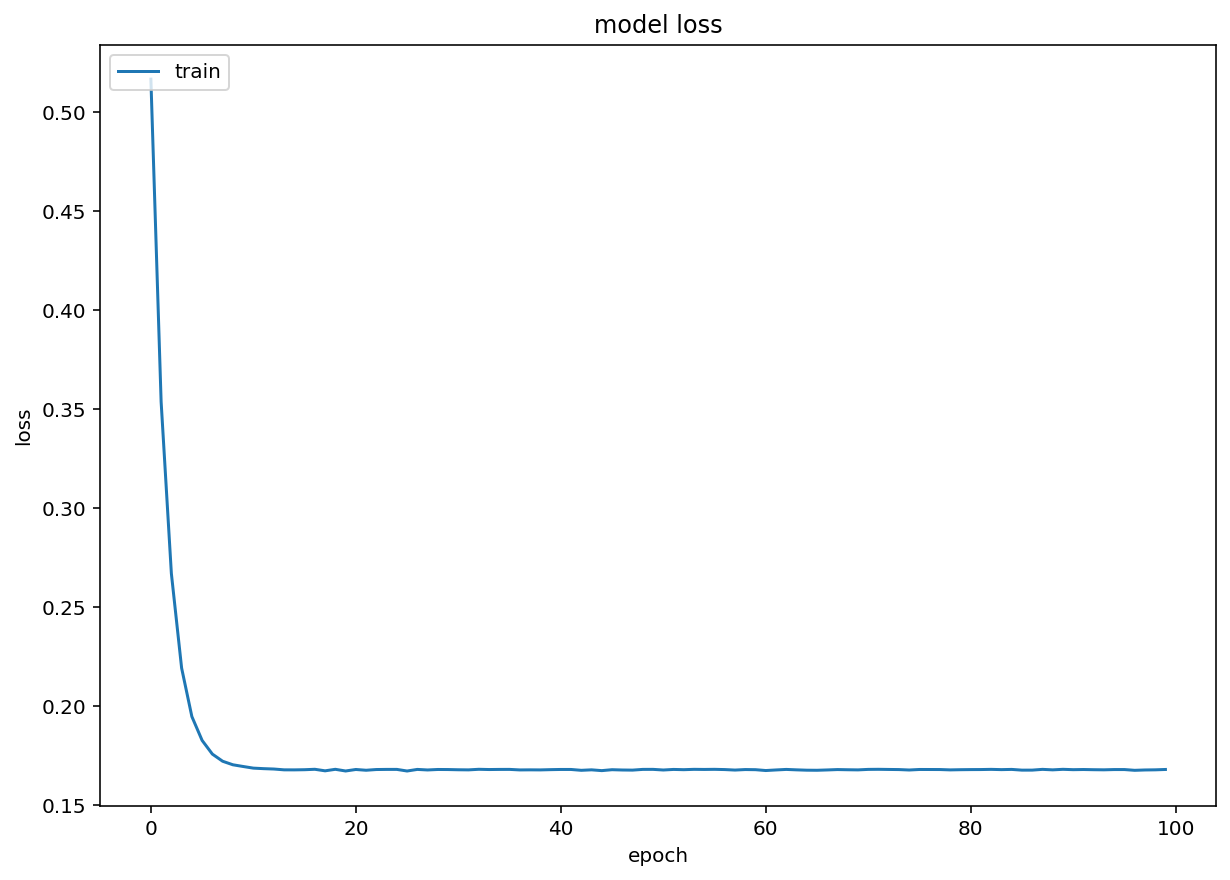

In [15]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [16]:
def split_batch_predict(data, num_qubits, model):
    
    splitted_X = None

    if num_qubits > 1:
        num_sections = ceil(X_.shape[0] / num_qubits)
        splitted_X = np.array_split(data.flatten(), num_sections)
    else:
        splitted_X = data

    y_prediction = []

    for arr in splitted_X:
        pred = model.predict(arr)
        y_prediction.append(pred.tolist())
    
    return np.array(y_prediction)

In [17]:
y_predict = split_batch_predict(X_, n_qubits, model)

In [18]:
y_predict_smooth = smooth(y_predict)

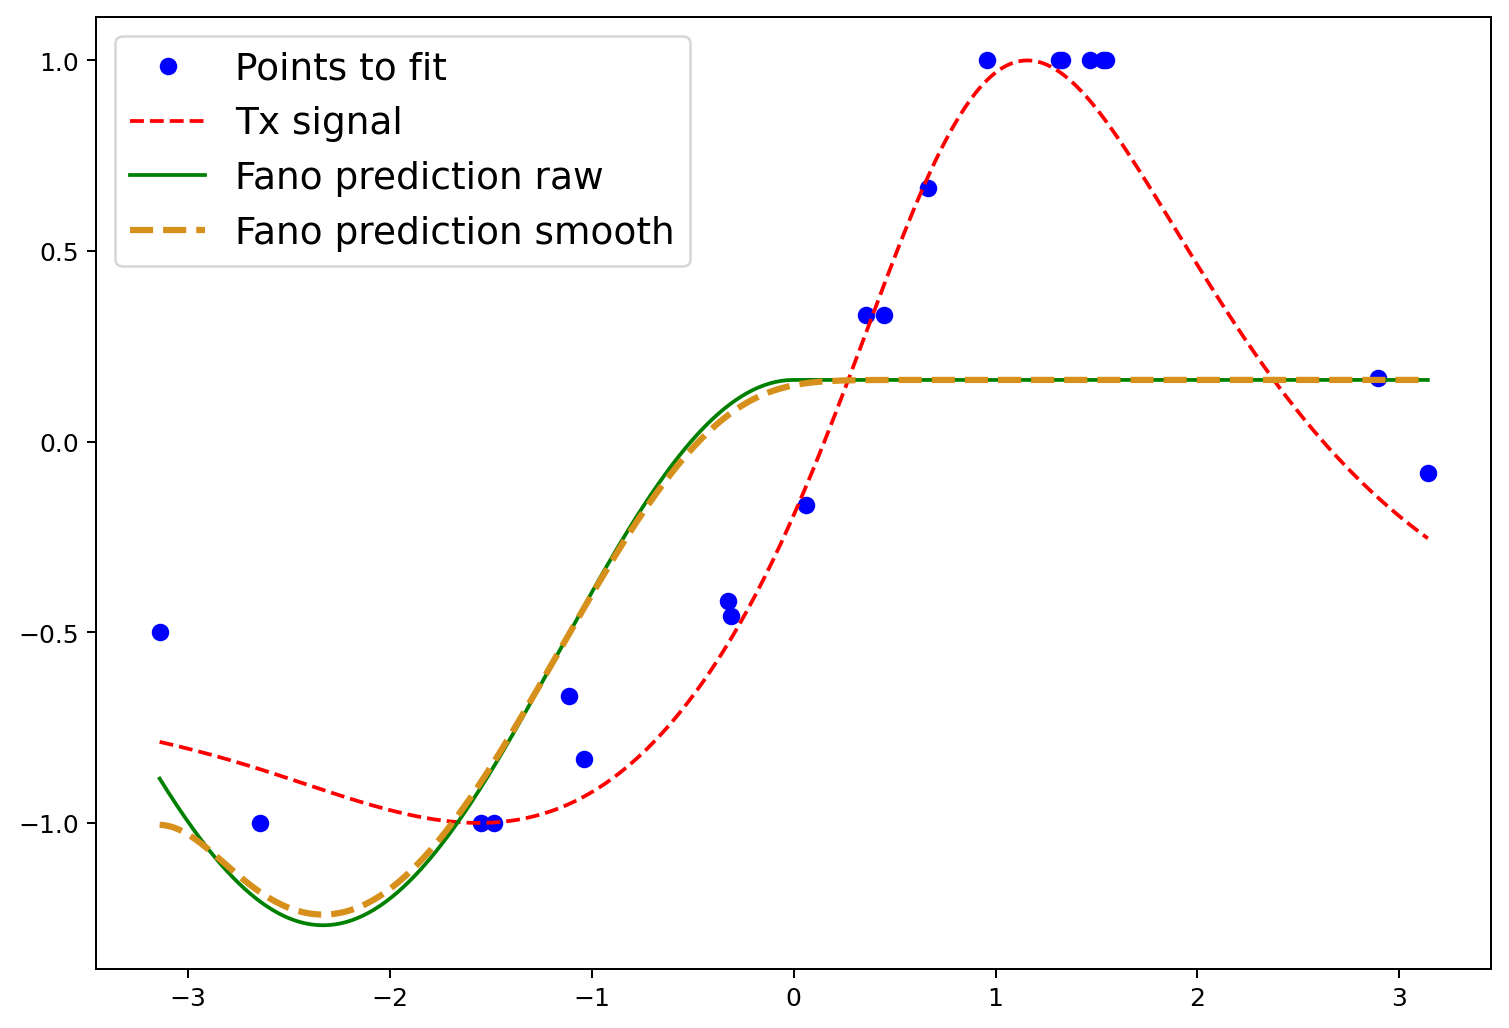

In [19]:
plt.figure(num = "Fano adjust QML 1", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')

# plot data
plt.plot(XX, yy, "bo", label = 'Points to fit')

# plot target function
plt.plot(X_, y_, "r--", label = 'Tx signal')

# plot prediction
plt.plot(X_, y_predict.flatten(), "g-", label = 'Fano prediction raw')
plt.plot(X_, y_predict_smooth.flatten(), "--", color='#d7901b', linewidth=2.5, label = 'Fano prediction smooth')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

In [20]:
print("Score: %.10f" % r2_score(y_, y_predict.flatten()))

Score: 0.5905903725


In [21]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright